In [1]:
import pandas as pd 
df = pd.read_csv("train.csv")

In [2]:
df[:3]

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32


In [3]:
df = df.sample(frac=1) 

In [4]:
df['season'].value_counts()

4    2734
3    2733
2    2733
1    2686
Name: season, dtype: int64

In [5]:
df['workingday'].value_counts()

1    7412
0    3474
Name: workingday, dtype: int64

In [6]:
df['holiday'].value_counts()

0    10575
1      311
Name: holiday, dtype: int64

In [7]:
df['weather'].value_counts()

1    7192
2    2834
3     859
4       1
Name: weather, dtype: int64

In [8]:
df[:3]

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
3089,2011-07-17 15:00:00,3,0,0,1,33.62,37.12,43,19.9995,129,195,324
2504,2011-06-12 06:00:00,2,0,0,1,25.42,28.03,88,7.0015,5,9,14
6236,2012-02-16 02:00:00,1,0,1,2,12.30,15.91,70,6.0032,1,6,7


In [9]:
import datetime

In [10]:
df['date']  = df.datetime.apply(lambda x: x.split()[0])
df['hour'] = df.datetime.apply(lambda x: x.split()[1].split(':')[0])
df['weekday'] = df.date.apply(lambda dateString : datetime.datetime.strptime(dateString, '%Y-%m-%d').weekday())
df['month'] = df.date.apply(lambda dateString : datetime.datetime.strptime(dateString, '%Y-%m-%d').month)
df['month_day'] = df.date.apply(lambda dateString : datetime.datetime.strptime(dateString, '%Y-%m-%d').day)

In [11]:
df = df.drop('datetime',axis=1)
df = df.drop('casual',axis=1)
df = df.drop('registered',axis=1)
df = df.drop('date',axis=1)
preds  = df['count']
df = df.drop('count',axis=1)

In [12]:
preds.describe( )

count    10886.000000
mean       191.574132
std        181.144454
min          1.000000
25%         42.000000
50%        145.000000
75%        284.000000
max        977.000000
Name: count, dtype: float64

In [13]:
df[:3]

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,hour,weekday,month,month_day
3089,3,0,0,1,33.62,37.12,43,19.9995,15,6,7,17
2504,2,0,0,1,25.42,28.03,88,7.0015,06,6,6,12
6236,1,0,1,2,12.30,15.91,70,6.0032,02,3,2,16


In [14]:
categorical_vars = ["hour", "month", "weekday","season","weather","month_day"]

In [15]:
all_cols = df.columns

In [16]:
all_cols

Index([u'season', u'holiday', u'workingday', u'weather', u'temp', u'atemp',
       u'humidity', u'windspeed', u'hour', u'weekday', u'month', u'month_day'],
      dtype='object')

In [17]:
other_cols = [i for i in all_cols if i not in categorical_vars ]

In [18]:
other_cols

['holiday', 'workingday', 'temp', 'atemp', 'humidity', 'windspeed']

In [19]:
import numpy as np 
def preproc(X_train ) : 

    input_list_train = []
    for c in categorical_vars :
        
        jjj = np.asarray(X_train[c].tolist())
        jjj = pd.factorize( jjj )[0]
        input_list_train.append( np.asarray(jjj)  )
        """
        raw_vals = np.unique(X_train[c])
        val_map = {}
        for i in range(len(raw_vals)):
            val_map[raw_vals[i]] = i       
        input_list_train.append(X_train[c].map(val_map).values)
        """
    #the rest of the columns
    input_list_train.append(X_train[other_cols].values)
    return input_list_train 
df_tr = preproc( df )

In [20]:
from keras.layers import *
from keras.models import *

models = []

for categoical_var in categorical_vars :
    model = Sequential()
    model.reset_states( )
    no_of_unique_cat  = df[categoical_var].nunique()
    embedding_size = min(np.ceil((no_of_unique_cat)/2), 50 )
    embedding_size = int(embedding_size)
    model.add(  Embedding( no_of_unique_cat+1, embedding_size, input_length = 1 ) )
    model.add(Reshape(target_shape=(embedding_size,)))
    models.append( model )


model_rest = Sequential()
model_rest.add(Dense(  64 , input_dim = 6 ))
model_rest.reset_states( )
models.append(model_rest)
 
full_model = Sequential()
full_model.add(Merge(models, mode='concat'))

full_model.add(Dense(512))
full_model.add(Activation('sigmoid'))
full_model.add(Dropout(0.2))

full_model.add(Dense(32))
full_model.add(Activation('sigmoid'))
full_model.add(Dropout(0.2))

full_model.add(Dense(1))

full_model.compile(loss='mean_squared_error', optimizer='Adam',metrics=['mse','mape'])  

/home/ms/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/ms/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:23: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.


In [21]:
full_model = Sequential()
full_model.reset_states( )
full_model.add(Merge(models, mode='concat'))
full_model.add(Dense( 256 , activation='sigmoid'))
full_model.add(Dense(32, activation='sigmoid'))
full_model.add(Dropout(0.2))
full_model.add(Dense(1 ))

full_model.compile(loss='mean_squared_error', optimizer='Adam' ,metrics=['mse','mape'])

/home/ms/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  This is separate from the ipykernel package so we can avoid doing imports until


In [37]:
history  =  full_model.fit( df_tr  , preds  , epochs =  200 , batch_size = 16, verbose= 1  )

Epoch 1/200
10886/10886 [==============================] - 1s 85us/step - loss: 8450.5882 - mean_squared_error: 8450.5882 - mean_absolute_percentage_error: 54.0903
Epoch 2/200
10886/10886 [==============================] - 1s 87us/step - loss: 8022.7003 - mean_squared_error: 8022.7003 - mean_absolute_percentage_error: 52.2364
Epoch 3/200
10886/10886 [==============================] - 1s 88us/step - loss: 7923.3770 - mean_squared_error: 7923.3770 - mean_absolute_percentage_error: 51.9840
Epoch 4/200
10886/10886 [==============================] - 1s 88us/step - loss: 7697.5727 - mean_squared_error: 7697.5727 - mean_absolute_percentage_error: 51.5064
Epoch 5/200
10886/10886 [==============================] - 1s 82us/step - loss: 7534.5718 - mean_squared_error: 7534.5718 - mean_absolute_percentage_error: 51.4228
Epoch 6/200
10886/10886 [==============================] - 1s 91us/step - loss: 7254.3911 - mean_squared_error: 7254.3911 - mean_absolute_percentage_error: 49.9628
Epoch 7/200
1088

10886/10886 [==============================] - 1s 88us/step - loss: 1882.3305 - mean_squared_error: 1882.3305 - mean_absolute_percentage_error: 38.7772
Epoch 100/200
10886/10886 [==============================] - 1s 92us/step - loss: 1873.3490 - mean_squared_error: 1873.3490 - mean_absolute_percentage_error: 39.7555
Epoch 101/200
10886/10886 [==============================] - 1s 93us/step - loss: 1827.6304 - mean_squared_error: 1827.6304 - mean_absolute_percentage_error: 40.3853
Epoch 102/200
10886/10886 [==============================] - 1s 87us/step - loss: 1817.9841 - mean_squared_error: 1817.9841 - mean_absolute_percentage_error: 40.3415
Epoch 103/200
10886/10886 [==============================] - 1s 86us/step - loss: 1897.6045 - mean_squared_error: 1897.6045 - mean_absolute_percentage_error: 38.4329
Epoch 104/200
10886/10886 [==============================] - 1s 86us/step - loss: 1794.0691 - mean_squared_error: 1794.0691 - mean_absolute_percentage_error: 40.1556
Epoch 105/200
1088

10886/10886 [==============================] - 1s 88us/step - loss: 1351.6199 - mean_squared_error: 1351.6199 - mean_absolute_percentage_error: 42.4884
Epoch 198/200
10886/10886 [==============================] - 1s 88us/step - loss: 1346.1430 - mean_squared_error: 1346.1430 - mean_absolute_percentage_error: 41.8846
Epoch 199/200
10886/10886 [==============================] - 1s 89us/step - loss: 1277.9160 - mean_squared_error: 1277.9160 - mean_absolute_percentage_error: 45.1603
Epoch 200/200
10886/10886 [==============================] - 1s 88us/step - loss: 1359.1014 - mean_squared_error: 1359.1014 - mean_absolute_percentage_error: 43.4700


In [38]:
history.params

{'batch_size': 16,
 'do_validation': False,
 'epochs': 200,
 'metrics': ['loss', 'mean_squared_error', 'mean_absolute_percentage_error'],
 'samples': 10886,
 'steps': None,
 'verbose': 1}

In [39]:
loss = history.history['loss']
mse = history.history['mean_squared_error']
mape = history.history['mean_absolute_percentage_error']

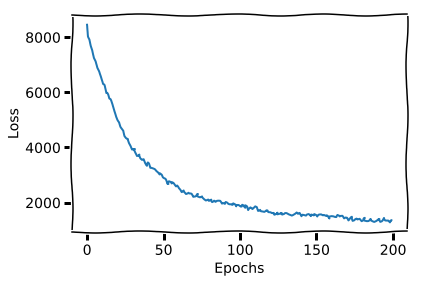

In [40]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.xkcd()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot( loss  )


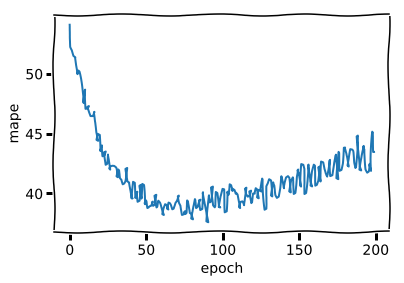

In [41]:
plt.xlabel("epoch")
plt.ylabel("mape")
plt.plot( mape )

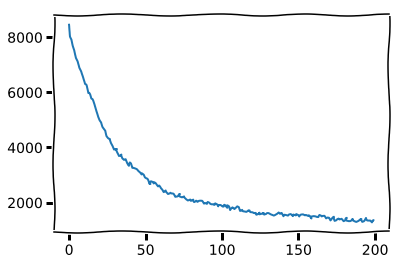

In [42]:
plt.plot( mse)